# Import Libraries

In [1]:
import pathlib
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt

import tensorflow
print("TensorFlow version:", tensorflow.__version__)

import tensorflow.compat.v2 as tf

TensorFlow version: 2.0.0


# Notebook Parameters

In [2]:
classes = ["not_ship", "ship"]
N_THREADS = multiprocessing.cpu_count()
BATCH_SIZE = 16

# Loading Data

## Loading our Imagery Dataset

In [3]:
dataset_path = pathlib.Path("./ships-imagery-dataset/")

image_count = len(list(dataset_path.glob('*/*.jpg')))
print("Total images:", image_count)

list_ds = tf.data.Dataset.list_files(str(dataset_path/'*/*.jpg'),
                                     shuffle=True)

Total images: 555


### Functions to Preprocess Images

In [4]:
@tf.function
def load_train_example(file_path):
    label = tf.strings.split(file_path, '/')[-2]
    if label == "ship":
        _label = 1
    else:
        _label = 0
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = img/127.5 - 1
    img = tf.image.resize(img, [224, 224])
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    rot_k = np.random.randint(0, 4, size=1)[0]
    img = tf.image.rot90(img, rot_k)
    return img, tf.one_hot(_label, 2)

@tf.function
def load_test_example(file_path):
    label = tf.strings.split(file_path, '/')[-2]
    if label == "ship":
        _label = 1
    else:
        _label = 0
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = img/127.5 - 1
    img = tf.image.resize(img, [224, 224])
    return img, tf.one_hot(_label, 2)

### Building Input Pipelines

In [5]:
train_dataset = list_ds.shard(3, 0)
train_dataset = train_dataset.map(load_train_example, num_parallel_calls=N_THREADS)
train_dataset = train_dataset.repeat(-1)
train_dataset = train_dataset.shuffle(image_count//3)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(8)

val_dataset = list_ds.shard(3, 1)
val_dataset = val_dataset.map(load_test_example, num_parallel_calls=N_THREADS)
val_dataset = val_dataset.repeat(-1)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(8)

inf_dataset = list_ds.shard(3, 2)
inf_dataset = inf_dataset.map(load_test_example, num_parallel_calls=N_THREADS)
inf_dataset = inf_dataset.repeat(-1)
inf_dataset = inf_dataset.batch(1)
inf_dataset = inf_dataset.prefetch(32)

# run pipeline once
_, _, _ = train_dataset.take(1), val_dataset.take(1), inf_dataset.take(1)

## Build Model

In [6]:
import tensorflow.keras.layers as layers
import tensorflow.keras.applications as models

def create_model(img_size=(224,224), num_class=2, train_base=True):
    input_layer = layers.Input(shape=(img_size[0],img_size[1],3))
    base = models.densenet.DenseNet121(input_tensor=input_layer,
                                       include_top=False,
                                       weights="imagenet")
    base.trainable = train_base
    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(rate=0.2)(x)
    preds = layers.Dense(num_class, activation="softmax")(x)
    return tf.keras.models.Model(inputs=input_layer, outputs=preds)

In [7]:
model = create_model((224, 224), len(classes), train_base=True)

opt = tf.keras.optimizers.SGD()

model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["acc"])

## Train Model

In [8]:
train_steps = int(image_count/3/BATCH_SIZE)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(train_dataset, steps_per_epoch=train_steps,
                    validation_data=val_dataset, validation_steps=train_steps,
                    callbacks=[early_stop], epochs=20, verbose=2)

Train for 11 steps, validate for 11 steps
Epoch 1/20
11/11 - 22s - loss: 0.5208 - acc: 0.7216 - val_loss: 0.4563 - val_acc: 0.7841
Epoch 2/20
11/11 - 1s - loss: 0.3261 - acc: 0.8523 - val_loss: 0.5227 - val_acc: 0.7727
Epoch 3/20
11/11 - 1s - loss: 0.3250 - acc: 0.8636 - val_loss: 0.6880 - val_acc: 0.6477
Epoch 4/20
11/11 - 2s - loss: 0.1829 - acc: 0.9261 - val_loss: 0.3203 - val_acc: 0.8750
Epoch 5/20
11/11 - 1s - loss: 0.2539 - acc: 0.9318 - val_loss: 0.5520 - val_acc: 0.7557
Epoch 6/20
11/11 - 1s - loss: 0.2774 - acc: 0.8920 - val_loss: 0.5613 - val_acc: 0.7330
Epoch 7/20
11/11 - 1s - loss: 0.1702 - acc: 0.9489 - val_loss: 0.3834 - val_acc: 0.8125
Epoch 8/20
11/11 - 1s - loss: 0.0884 - acc: 0.9773 - val_loss: 0.3628 - val_acc: 0.8352
Epoch 9/20
11/11 - 1s - loss: 0.1397 - acc: 0.9489 - val_loss: 0.6771 - val_acc: 0.7443
Epoch 10/20
11/11 - 2s - loss: 0.1025 - acc: 0.9545 - val_loss: 0.2016 - val_acc: 0.9205
Epoch 11/20
11/11 - 1s - loss: 0.1421 - acc: 0.9432 - val_loss: 0.3438 - val

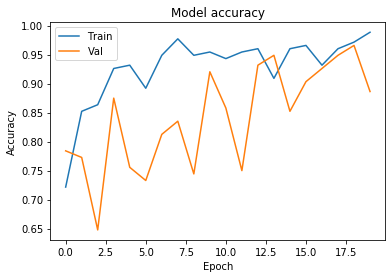

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [10]:
loss, acc = model.evaluate(inf_dataset, steps=image_count//2)
print("Model test accuracy:", round(acc*100, 1), "%")

277/277 [==============================] - 7s 27ms/step - loss: 0.2856 - acc: 0.9061
Model test accuracy: 90.6 %


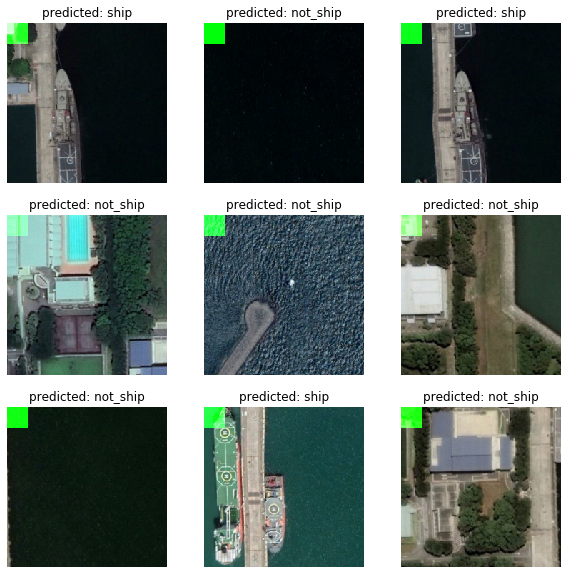

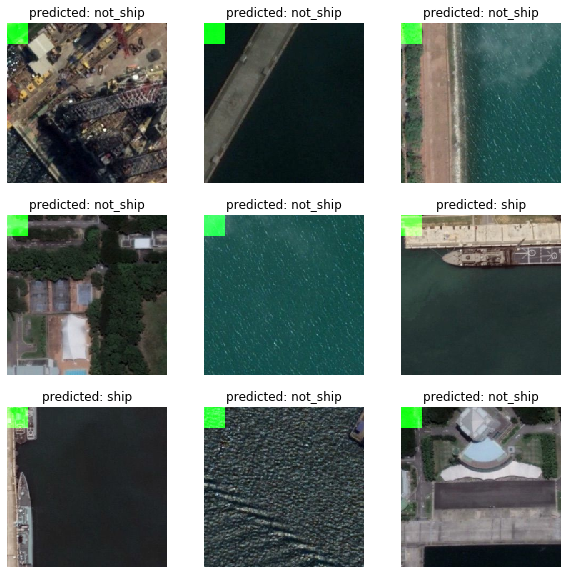

In [11]:
for _ in range(2):
    plt.figure(figsize=(10,10))
    i = 0
    for batch in inf_dataset.take(9):
        plt.subplot(3,3,i+1)
        image, label = batch
        pred = model.predict(image)
        title = "predicted: " + classes[np.argmax(pred)]
        img = (tf.cast(image[0], tf.float32).numpy() + 1) * 127.5
        img = img.astype("int")
        if np.argmax(label.numpy()) == np.argmax(pred):
            img[:30, :30, 1] = 255
        else:
            img[:30, :30, 0] = 255
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")
        i += 1
    plt.show()